# Download Dataset

In [ ]:
!pip install gdown

# Download data.zip using gdown
!gdown --id 1qOFMiAqwkkBw3TDOYQJ6fwH-Mk1dUzuV -O data.zip

# Unzip the downloaded file
!unzip data.zip


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qOFMiAqwkkBw3TDOYQJ6fwH-Mk1dUzuV
To: /content/data.zip
100% 124M/124M [00:03<00:00, 37.5MB/s]
Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/adenocarcinoma/
  inflating: data/test/adenocarcinoma/000108 (3).png  
  inflating: data/test/adenocarcinoma/000109 (2).png  
  inflating: data/test/adenocarcinoma/000109 (4).png  
  inflating: data/test/adenocarcinoma/000109 (5).png  
  inflating: data/test/adenocarcinoma/000112 (2).png  
  inflating: data/test/adenocarcinoma/000113 (7).png  
  inflating: data/test/adenocarcinoma/000114 (5).png  
  inflating: data/test/adenocarcinoma/000114.png  
  inflating: data/test/adenocarcinoma/000115 (4).png  
  inflating: data/test/adenocarcinoma/000115 

# The *Imports*

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
import tensorflow

import matplotlib.pyplot as plt
import numpy as np

import cv2 as cv
import os





# Function for Loading and preprocessing Images




In [ ]:
def load_and_sharpen_images_from_subdirectories(parent_directory, subdirectories, target_size=(224, 224)):
    images = []
    labels = []  # Store corresponding labels
    for subdir in subdirectories:
        subdir_path = os.path.join(parent_directory, subdir)
        files = os.listdir(subdir_path)
        for file in files:
            image_path = os.path.join(subdir_path, file)
            if os.path.isfile(image_path):
                # Read image in grayscale
                image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
                if image is not None:

                    edges = cv.Canny(image, 100, 200)  # You can adjust these thresholds for edge detection
                     # Create a mask using the edges (inverted)
                    mask = cv.bitwise_not(edges)  # Invert the edges to obtain the mask

                    # Convert grayscale to RGB by replicating the single channel to three channels
                    image_rgb = cv.merge((image, image, image))
                    # Apply the mask to the image

                    masked_image = cv.bitwise_and(image_rgb, image_rgb, mask=mask)

                    # Resize to target size
                    image_resized = cv.resize(image_rgb, target_size)
                    # print(image_resized.shape)
                    images.append(image_resized)

                    # Assign label based on directory name
                    if subdir == 'normal':
                        labels.append([1, 0])  # Non-cancerous label (1, 0) for one-hot encoding
                    else:
                        labels.append([0, 1])  # Cancerous label (0, 1) for one-hot encoding
    print(images[0].shape)

    return np.array(images), np.array(labels)

# Directory paths for train, validation, and test sets


In [ ]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

subdirectories = ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

# Load and sharpen images from subdirectories within train_dir


In [ ]:
train_images,train_labels = load_and_sharpen_images_from_subdirectories(train_dir, subdirectories)
valid_images,valied_labels = load_and_sharpen_images_from_subdirectories(valid_dir, subdirectories)
test_images,test_labels = load_and_sharpen_images_from_subdirectories(test_dir, ['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma'])

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


# Display the number of loaded images


In [ ]:
print("Number of loaded train images:", len(train_images))
print("Number of loaded test images:", len(test_images))
print("Number of loaded valid images:", len(valid_images))

Number of loaded train images: 613
Number of loaded test images: 315
Number of loaded valid images: 72


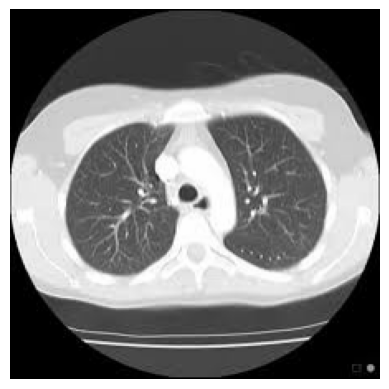

(224, 224, 3)

In [ ]:
plt.imshow(train_images[0])  # Show the first image, change the index for different images
plt.axis('off')  # Hide the axes
plt.show()
train_images[100].shape

# Model Architecture

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)  # Replace the final layer with a Dense layer having 2 output classes (for binary classification)

model = Model(inputs=base_model.input, outputs=x)

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

epochs = 5

history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    validation_data=(valid_images, valied_labels)
)

Epoch 1/5
20/20 [==============================] - 146s 7s/step - loss: 0.4477 - accuracy: 0.8238 - val_loss: 0.0952 - val_accuracy: 0.9861
Epoch 2/5
20/20 [==============================] - 132s 7s/step - loss: 0.1324 - accuracy: 0.9625 - val_loss: 0.0546 - val_accuracy: 0.9861
Epoch 3/5
20/20 [==============================] - 130s 7s/step - loss: 0.0834 - accuracy: 0.9690 - val_loss: 0.0416 - val_accuracy: 0.9861
Epoch 4/5
20/20 [==============================] - 141s 7s/step - loss: 0.0668 - accuracy: 0.9837 - val_loss: 0.0474 - val_accuracy: 0.9861
Epoch 5/5
20/20 [==============================] - 145s 7s/step - loss: 0.0572 - accuracy: 0.9902 - val_loss: 0.0447 - val_accuracy: 0.9861


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


10/10 [==============================] - 60s 6s/step - loss: 0.0224 - accuracy: 0.9968
Test Loss: 0.022446531802415848
Test Accuracy: 0.9968253970146179


# Grad-CAM Impementation

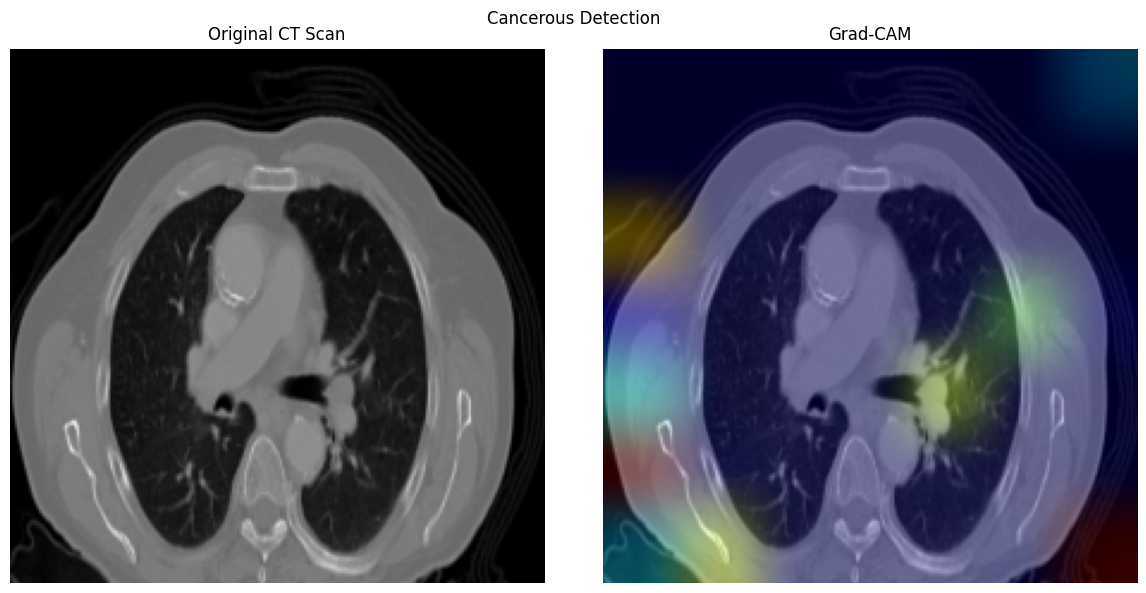

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

def plot_gradcam(img_arrays, heatmap,image_id, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    heatmap = jet(heatmap)

    heatmap = image.array_to_img(heatmap)
    heatmap = heatmap.resize((img_arrays[image_id].shape[1], img_arrays[image_id].shape[0]))
    heatmap = image.img_to_array(heatmap)

    superimposed_img = heatmap[..., :3] * alpha + img_arrays[image_id]
    superimposed_img = image.array_to_img(superimposed_img)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    plt.suptitle("Cancerous Detection")


    # Plot the original CT scan image in the second subplot
    axes[0].imshow(valid_images[image_id])
    axes[0].set_title('Original CT Scan')
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    plt.tight_layout()

    plt.axis('off')
    plt.show()

# Replace 'conv5_block3_out' with your desired layer name
last_conv_layer_name = 'conv5_block1_out'

# Generate the heatmap
img_for_heatmap = np.expand_dims(train_images[0], axis=0)  # Add batch dimension
heatmap = make_gradcam_heatmap(img_for_heatmap, model, last_conv_layer_name)


plot_gradcam(valid_images,heatmap,20)


# Generating Adveresrial Pattern


In [ ]:
loss_object = tensorflow.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    input_image = tensorflow.convert_to_tensor(input_image, dtype=tensorflow.float32)
    input_label = tensorflow.convert_to_tensor(input_label, dtype=tensorflow.float32)

    with tensorflow.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tensorflow.sign(gradient)
    return signed_grad

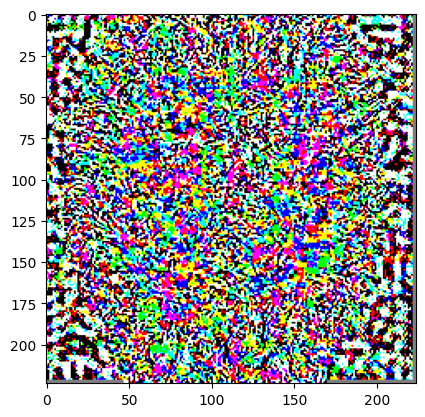

In [ ]:
test_img = np.expand_dims(train_images[1], axis=0)
label = np.expand_dims(train_labels[1], axis=0)  # Adjust label shape if needed

perturbations = create_adversarial_pattern(test_img, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

# Applyting Patterns for Different Epsilons

In [ ]:
def display_images(image, description):
  # _, label, confidence = get_imagenet_label(model.predict(image))
    plt.imshow(image)  # Show the first image, change the index for different images
    plt.axis('off')  # Hide the axes
    plt.show()

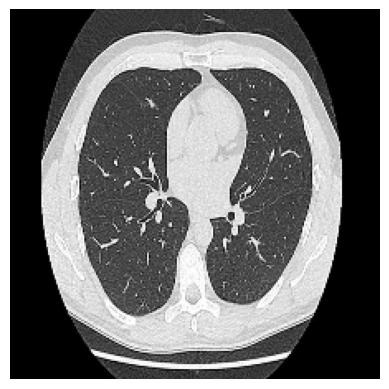

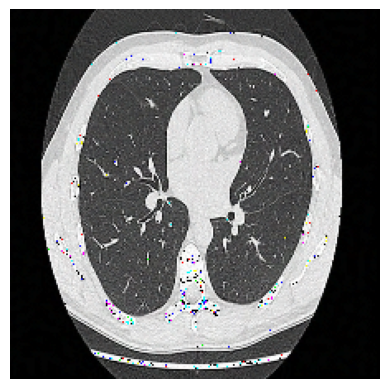

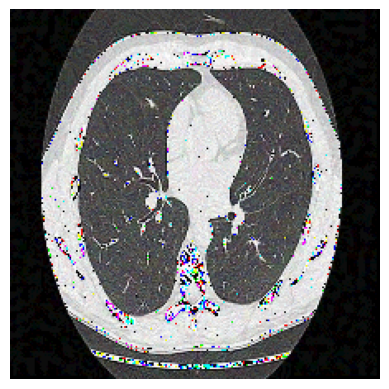

In [ ]:
epsilons = [0.001,3,12]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]
uint8_tensor = tensorflow.cast(perturbations[0], tensorflow.uint8)
for i, eps in enumerate(epsilons):
  adv_x = train_images[1] +tensorflow.cast(eps* perturbations[0],tensorflow.uint8)
  display_images(adv_x, descriptions[i])

# Adveserial Training

In [ ]:
def creating_adverserial_data(images):
  epsilons = [0.001,1,12]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]
  uint8_tensor = tensorflow.cast(perturbations[0], tensorflow.uint8)
  for i, eps in enumerate(epsilons):
    adv_x = train_images[1] +tensorflow.cast(eps* perturbations[0],tensorflow.uint8)
    display_images(adv_x, descriptions[i])

In [ ]:
def adversarial_training(model, images, labels, epochs=5, epsilon=0.01):
    for epoch in range(epochs):
        perturbed_images = fgsm_attack(model, images, labels, epsilon)
        model.fit(perturbed_images, labels, epochs=1)

In [ ]:
model.summary()